---
# 1. Import Libraries

In [37]:
# Core libraries
import numpy as np 
import pandas as pd
from datetime import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Sklearn preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Traditional models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Advanced boosting models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


---
# 2. Data Loading & Initial Exploration

In [38]:
# Load data
df = pd.read_csv('avito_final_results.csv')
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
df.head()

Dataset shape: (16059, 14)
Memory usage: 1.72 MB


,URL,Title,Price_Raw,Année-Modèle,Boite de vitesses,Type de carburant,Kilométrage,Marque,Modèle,Nombre de portes,Origine,Première main,Puissance fiscale,État
0,https://www.avito.ma/fr/riad_oulad_mtaa/voitur...,Nissan Qashqai Diesel 2016,173 000 DH,2016,Manuelle,Diesel,150.0,Nissan,Qashqai,5.0,WW au Maroc,Oui,6 CV,Excellent
1,https://www.avito.ma/fr/centre_ville/voitures_...,Tiguan R LINE,Demander le prix,2022,Automatique,Diesel,102000.0,Volkswagen,Tiguan,5.0,Dédouanée,Oui,8 CV,Excellent
2,https://www.avito.ma/fr/jawhara/voitures_d_occ...,BMW Série 2 Diesel Automatique 2023 à El Jadida,Demander le prix,2023,Automatique,Diesel,50000.0,BMW,Série 2,5.0,WW au Maroc,Oui,8 CV,Excellent
3,https://www.avito.ma/fr/oulfa/voitures_d_occas...,Mercedes-Benz Classe A Diesel Automatique 2022,Demander le prix,2022,Automatique,Diesel,45000.0,Mercedes-Benz,Classe A,5.0,WW au Maroc,Oui,8 CV,Excellent
4,https://www.avito.ma/fr/salama/voitures_d_occa...,Renault Megane 2023 Excellent état,195 000 DH,2023,Automatique,Diesel,100000.0,Renault,Megane,5.0,WW au Maroc,Non,6 CV,Bon


---
# 3. Data Cleaning (Same as Original)

In [39]:
# Drop unnecessary columns
df = df.drop(columns=['URL', 'Title'])

# Clean price
df['price'] = (
    df['Price_Raw']
    .astype(str)
    .str.replace(r'\D+', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)
df = df.dropna(subset=['price'])
df['price'] = df['price'].astype(int)
df = df.drop(columns=['Price_Raw'])

# Convert numeric features
df['Kilométrage'] = pd.to_numeric(df['Kilométrage'], errors='coerce')
df['Year'] = pd.to_numeric(df['Année-Modèle'], errors='coerce')
df['Age'] = 2025 - df['Year']
df['Puissance fiscale'] = (
    df['Puissance fiscale']
    .astype(str)
    .str.replace(r'\D+', '', regex=True)
    .replace('', '0')
    .astype(int)
)

# Drop rows with missing critical features
df = df.dropna(subset=[
    'Année-Modèle', 'Boite de vitesses', 'Type de carburant',
    'Kilométrage', 'Marque', 'Modèle', 'Year', 'Age', 'Origine', 'État'
])

# Fill missing values for less critical features
df['Nombre de portes'].fillna(df['Nombre de portes'].mode()[0], inplace=True)
df['Puissance fiscale'].fillna(df['Puissance fiscale'].mode()[0], inplace=True)
df['Première main'].fillna('Non', inplace=True)

# Remove outliers using IQR method
def remove_outliers_iqr(df, column, factor=2.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'price', factor=2.0)
df = remove_outliers_iqr(df, 'Kilométrage', factor=2.0)
df = df[df['Puissance fiscale'] <= 15]
df = df[df['Age'] <= 35]
df = df[df['Year'] <= datetime.now().year]

print(f"\nFinal dataset shape: {df.shape}")
print(f"Rows retained: {len(df)}")


Final dataset shape: (3851, 14)
Rows retained: 3851


In [40]:
df.drop(columns=['Année-Modèle'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [41]:
# Drop Autre marque
df = df[df['Marque'] != 'Autre']


---
# 4. Enhanced Feature Engineering

Creating powerful new features to boost model performance

In [42]:
# Basic derived features
df['mileage_per_year'] = df['Kilométrage'] / (df['Age'] + 1)
df['age_squared'] = df['Age'] ** 2

# NEW: Price-related features
df['power_age_ratio'] = df['Puissance fiscale'] / (df['Age'] + 1)

# NEW: Luxury brand indicator
luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Jaguar', 'Land Rover', 'Lexus']
df['is_luxury'] = df['Marque'].isin(luxury_brands).astype(int)

# NEW: Popular model indicator (top 20%)
model_counts = df['Modèle'].value_counts()
popular_threshold = model_counts.quantile(0.8)
df['is_popular_model'] = (df['Modèle'].map(model_counts) >= popular_threshold).astype(int)

# NEW: Mileage categories
df['mileage_category_low'] = (df['Kilométrage'] < 50000).astype(int)
df['mileage_category_medium'] = ((df['Kilométrage'] >= 50000) & (df['Kilométrage'] < 100000)).astype(int)

# NEW: Interaction features
df['year_power'] = df['Year'] * df['Puissance fiscale']
df['age_mileage_interaction'] = df['Age'] * df['Kilométrage'] / 10000  # Scaled

# NEW: Age bins
df['age_0_3'] = (df['Age'] <= 3).astype(int)
df['age_4_7'] = ((df['Age'] > 3) & (df['Age'] <= 7)).astype(int)
df['age_8_plus'] = (df['Age'] > 7).astype(int)

print("✓ Enhanced features created!")
print(f"Total features before encoding: {df.shape[1]}")

✓ Enhanced features created!
Total features before encoding: 25


In [43]:
def target_encoding_cv(df, column, target, n_folds=5):
    """
    Target encoding with cross-validation to prevent overfitting
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    encoded = np.zeros(len(df))
    global_mean = df[target].mean()
    
    for train_idx, val_idx in kf.split(df):
        # Calculate mean target for each category on training fold
        target_mean = df.iloc[train_idx].groupby(column)[target].mean()
        # Apply to validation fold, use global mean for unseen categories
        encoded[val_idx] = df.iloc[val_idx][column].map(target_mean).fillna(global_mean)
    
    return encoded

# Apply target encoding
print("Applying target encoding...")
df['brand_target_enc'] = target_encoding_cv(df, 'Marque', 'price')
df['model_target_enc'] = target_encoding_cv(df, 'Modèle', 'price')

# Keep frequency encoding as backup features
df['brand_freq'] = df['Marque'].map(df['Marque'].value_counts() / len(df))
df['model_freq'] = df['Modèle'].map(df['Modèle'].value_counts() / len(df))

print("✓ Target encoding completed!")

Applying target encoding...
✓ Target encoding completed!


---
# 6. One-Hot Encoding for Low-Cardinality Categoricals

In [44]:
# One-Hot Encoding
categorical_cols_ohe = ['Boite de vitesses', 'Type de carburant', 'Origine', 
                        'Première main', 'État']
df = pd.get_dummies(df, columns=categorical_cols_ohe, drop_first=True)

# Drop original high-cardinality columns
df.drop(columns=['Marque', 'Modèle'], inplace=True)

print(f"\nDataset shape after encoding: {df.shape}")
print(f"Total features: {df.shape[1] - 1}")


Dataset shape after encoding: (3850, 36)
Total features: 35


---
# 7. Train/Test Split & Scaling

In [45]:
# Separate features and target
X = df.drop(columns='price')
y = df['price']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify numeric columns to scale
numeric_features = ['Kilométrage', 'Age', 'Puissance fiscale', 'Nombre de portes', 
                    'mileage_per_year', 'age_squared', 'power_age_ratio',
                    'year_power', 'age_mileage_interaction', 'brand_target_enc',
                    'model_target_enc', 'brand_freq', 'model_freq']

# Scale
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print("✓ Data ready for modeling!")

Training set: 3080 samples
Test set: 770 samples
Number of features: 35
✓ Data ready for modeling!


---
# 8. Train Multiple Advanced Models

## 8.1 XGBoost

In [46]:
print("Training XGBoost...")
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("=" * 50)
print("XGBoost RESULTS")
print("=" * 50)
print(f"MAE:  {mae_xgb:,.2f} DH")
print(f"RMSE: {rmse_xgb:,.2f} DH")
print(f"R²:   {r2_xgb:.4f}")
print("=" * 50)

Training XGBoost...
XGBoost RESULTS
MAE:  22,253.23 DH
RMSE: 34,224.62 DH
R²:   0.8722


## 8.2 LightGBM

In [47]:
print("Training LightGBM...")
lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("=" * 50)
print("LightGBM RESULTS")
print("=" * 50)
print(f"MAE:  {mae_lgbm:,.2f} DH")
print(f"RMSE: {rmse_lgbm:,.2f} DH")
print(f"R²:   {r2_lgbm:.4f}")
print("=" * 50)

Training LightGBM...
LightGBM RESULTS
MAE:  22,577.73 DH
RMSE: 34,273.13 DH
R²:   0.8718


## 8.3 CatBoost

In [48]:
print("Training CatBoost...")
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=False
)

catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)

mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)

print("=" * 50)
print("CatBoost RESULTS")
print("=" * 50)
print(f"MAE:  {mae_catboost:,.2f} DH")
print(f"RMSE: {rmse_catboost:,.2f} DH")
print(f"R²:   {r2_catboost:.4f}")
print("=" * 50)

Training CatBoost...
CatBoost RESULTS
MAE:  23,294.77 DH
RMSE: 34,430.03 DH
R²:   0.8707


## 8.4 Original Gradient Boosting (Baseline)

In [49]:
print("Training Gradient Boosting (baseline)...")
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print("=" * 50)
print("Gradient Boosting RESULTS")
print("=" * 50)
print(f"MAE:  {mae_gbr:,.2f} DH")
print(f"RMSE: {rmse_gbr:,.2f} DH")
print(f"R²:   {r2_gbr:.4f}")
print("=" * 50)

Training Gradient Boosting (baseline)...
Gradient Boosting RESULTS
MAE:  23,660.57 DH
RMSE: 35,484.34 DH
R²:   0.8626


---
# 9. Model Ensemble

In [50]:
# Simple average ensemble
y_pred_ensemble = (y_pred_xgb + y_pred_lgbm + y_pred_catboost + y_pred_gbr) / 4

mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print("=" * 50)
print("ENSEMBLE MODEL RESULTS (Simple Average)")
print("=" * 50)
print(f"MAE:  {mae_ensemble:,.2f} DH")
print(f"RMSE: {rmse_ensemble:,.2f} DH")
print(f"R²:   {r2_ensemble:.4f}")
print("=" * 50)

ENSEMBLE MODEL RESULTS (Simple Average)
MAE:  22,281.12 DH
RMSE: 33,802.66 DH
R²:   0.8753


---
# 10. Comprehensive Model Comparison

In [51]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost', 'Gradient Boosting', 'Ensemble'],
    'MAE': [mae_xgb, mae_lgbm, mae_catboost, mae_gbr, mae_ensemble],
    'RMSE': [rmse_xgb, rmse_lgbm, rmse_catboost, rmse_gbr, rmse_ensemble],
    'R²': [r2_xgb, r2_lgbm, r2_catboost, r2_gbr, r2_ensemble]
})

# Sort by R² (descending)
results = results.sort_values('R²', ascending=False).reset_index(drop=True)

print("\n" + "=" * 80)
print("IMPROVED MODEL COMPARISON SUMMARY")
print("=" * 80)
print(results.to_string(index=False))
print("=" * 80)

# Calculate improvement
best_r2 = results['R²'].iloc[0]
baseline_r2 = 0.8259  # From original model
improvement = (best_r2 - baseline_r2) * 100

print(f"\n Best Model: {results['Model'].iloc[0]}")
print(f" R² Improvement: +{improvement:.2f}% over baseline")
print(f" New R²: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f" MAE Reduction: {32715 - results['MAE'].iloc[0]:,.0f} DH")


IMPROVED MODEL COMPARISON SUMMARY
            Model          MAE         RMSE       R²
         Ensemble 22281.121920 33802.661407 0.875325
          XGBoost 22253.230469 34224.615235 0.872193
         LightGBM 22577.725704 34273.134738 0.871831
         CatBoost 23294.766719 34430.026454 0.870655
Gradient Boosting 23660.567607 35484.344509 0.862612

 Best Model: Ensemble
 R² Improvement: +4.94% over baseline
 New R²: 0.8753 (87.53%)
 MAE Reduction: 10,434 DH


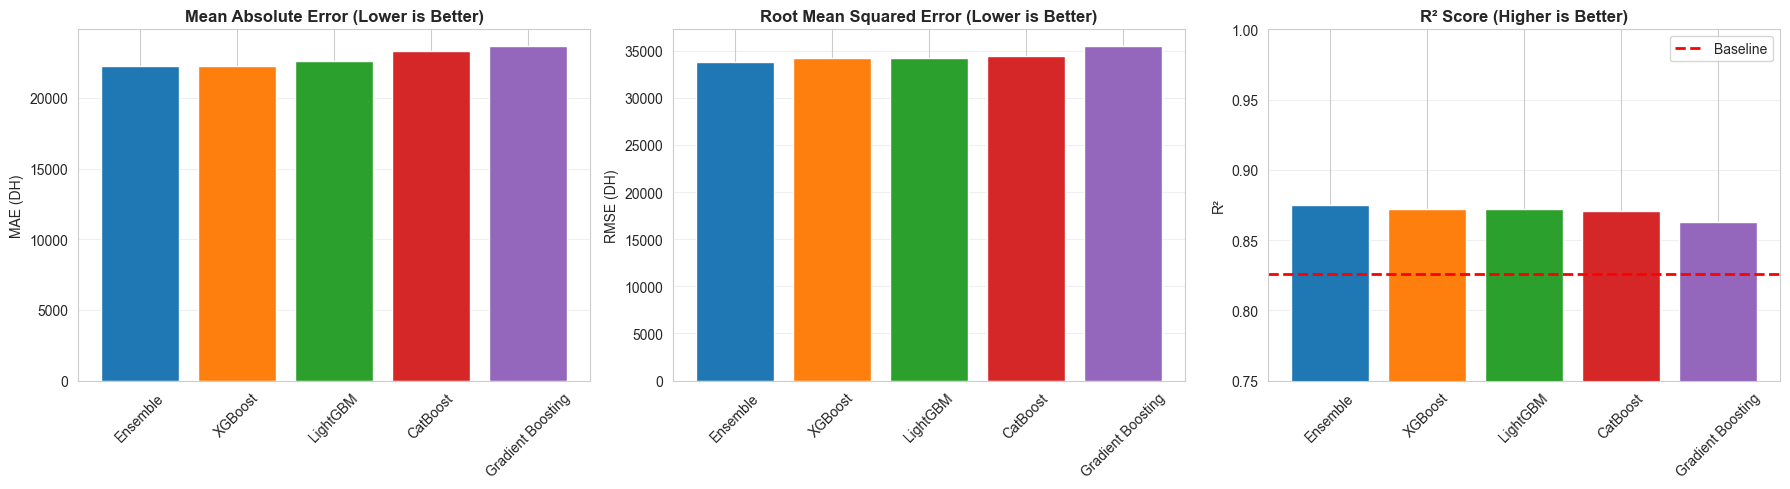

In [52]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# MAE comparison
axes[0].bar(results['Model'], results['MAE'], color=colors)
axes[0].set_title('Mean Absolute Error (Lower is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MAE (DH)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(results['Model'], results['RMSE'], color=colors)
axes[1].set_title('Root Mean Squared Error (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('RMSE (DH)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# R² comparison
axes[2].bar(results['Model'], results['R²'], color=colors)
axes[2].set_title('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('R²')
axes[2].set_ylim([0.75, 1.0])
axes[2].tick_params(axis='x', rotation=45)
axes[2].axhline(y=0.8259, color='r', linestyle='--', label='Baseline', linewidth=2)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
# 11. Feature Importance (Best Model)

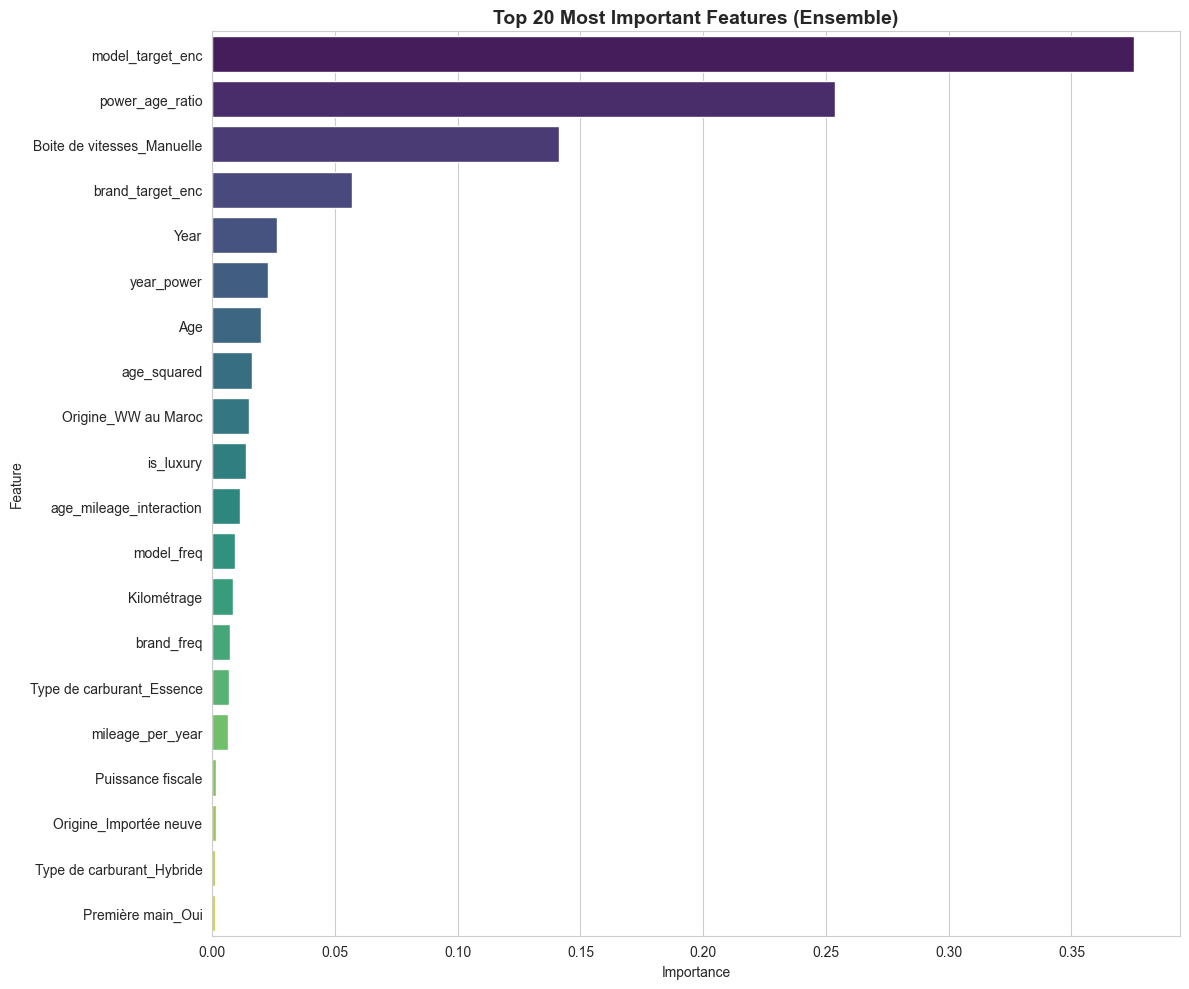


Top 15 Most Important Features:
model_target_enc............................. 0.3755
power_age_ratio.............................. 0.2538
Boite de vitesses_Manuelle................... 0.1414
brand_target_enc............................. 0.0569
Year......................................... 0.0265
year_power................................... 0.0225
Age.......................................... 0.0199
age_squared.................................. 0.0160
Origine_WW au Maroc.......................... 0.0148
is_luxury.................................... 0.0136
age_mileage_interaction...................... 0.0111
model_freq................................... 0.0091
Kilométrage.................................. 0.0083
brand_freq................................... 0.0072
Type de carburant_Essence.................... 0.0070


In [53]:
# Get best model
best_model_name = results['Model'].iloc[0]
if best_model_name == 'XGBoost':
    best_model = xgb_model
elif best_model_name == 'LightGBM':
    best_model = lgbm_model
elif best_model_name == 'CatBoost':
    best_model = catboost_model
else:
    best_model = gbr

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature', palette='viridis')
plt.title(f'Top 20 Most Important Features ({best_model_name})', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 15 Most Important Features:")
print("=" * 60)
for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:.<45} {row['importance']:.4f}")

---
# 12. Cross-Validation Analysis

In [54]:
print("Performing 5-fold cross-validation on best model...")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_model, X, y, cv=kfold, 
                            scoring='r2', n_jobs=-1)

print("=" * 50)
print("CROSS-VALIDATION RESULTS")
print("=" * 50)
print(f"Fold scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean R²: {cv_scores.mean():.4f}")
print(f"Std R²:  {cv_scores.std():.4f}")
print(f"95% CI:  {cv_scores.mean():.4f} ± {cv_scores.std() * 2:.4f}")
print("=" * 50)

Performing 5-fold cross-validation on best model...
CROSS-VALIDATION RESULTS
Fold scores: ['0.8631', '0.8294', '0.8846', '0.8751', '0.8888']
Mean R²: 0.8682
Std R²:  0.0213
95% CI:  0.8682 ± 0.0427


---
# 13. Prediction Analysis

In [55]:
# Use best model for predictions
if best_model_name == 'Ensemble':
    y_pred_best = y_pred_ensemble
elif best_model_name == 'XGBoost':
    y_pred_best = y_pred_xgb
elif best_model_name == 'LightGBM':
    y_pred_best = y_pred_lgbm
elif best_model_name == 'CatBoost':
    y_pred_best = y_pred_catboost
else:
    y_pred_best = y_pred_gbr

# Sample predictions
comparison = pd.DataFrame({
    'Actual': y_test[:20].values,
    'Predicted': y_pred_best[:20],
    'Difference': y_test[:20].values - y_pred_best[:20],
    'Error %': np.abs((y_test[:20].values - y_pred_best[:20]) / y_test[:20].values * 100)
})

print("\n" + "=" * 80)
print("SAMPLE PREDICTIONS (First 20 test samples)")
print("=" * 80)
print(comparison.to_string(index=False))
print("=" * 80)
print(f"\nAverage Error %: {comparison['Error %'].mean():.2f}%")
print(f"Median Error %: {comparison['Error %'].median():.2f}%")


SAMPLE PREDICTIONS (First 20 test samples)
 Actual     Predicted     Difference   Error %
 116000 127016.729658  -11016.729658  9.497181
 288000 402095.297144 -114095.297144 39.616423
 175000 200429.549399  -25429.549399 14.531171
 128000 130214.425893   -2214.425893  1.730020
 480000 470407.629443    9592.370557  1.998411
 159000 173282.061298  -14282.061298  8.982428
 107000 106729.563383     270.436617  0.252745
 148000 124382.129228   23617.870772 15.958021
 243000 229009.940397   13990.059603  5.757226
  60000  66799.225557   -6799.225557 11.332043
 202000 225708.253113  -23708.253113 11.736759
 230000 247090.670979  -17090.670979  7.430727
 105000 112859.559604   -7859.559604  7.485295
 260000 269756.054217   -9756.054217  3.752329
 168000 147193.393428   20806.606572 12.384885
 195000 180844.583384   14155.416616  7.259188
  45000  53377.548874   -8377.548874 18.616775
  69000  65127.765858    3872.234142  5.611934
 163000 140713.284509   22286.715491 13.672832
 114000 123286.1

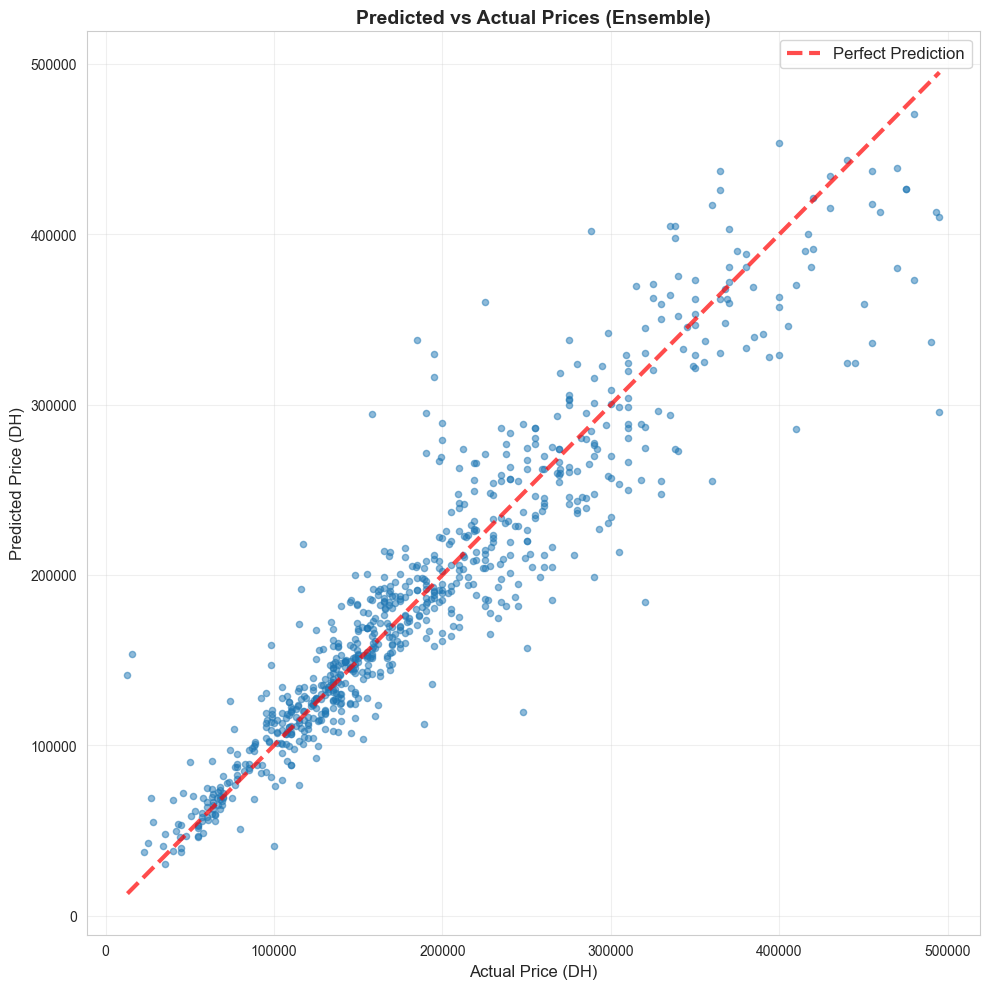

In [56]:
# Predicted vs Actual scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_best, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=3, label='Perfect Prediction', alpha=0.7)
plt.xlabel('Actual Price (DH)', fontsize=12)
plt.ylabel('Predicted Price (DH)', fontsize=12)
plt.title(f'Predicted vs Actual Prices ({best_model_name})', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
# 14. Save Improved Model

In [57]:
import pickle
import joblib

# Save the best model
with open('car_price_model_improved.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the scaler
with open('scaler_improved.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature names
feature_names = X_train.columns.tolist()
with open('feature_names_improved.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Save model metadata
best_idx = results.index[0]
model_metadata = {
    'model_type': best_model_name,
    'mae': results['MAE'].iloc[0],
    'rmse': results['RMSE'].iloc[0],
    'r2': results['R²'].iloc[0],
    'n_features': len(feature_names),
    'training_date': '2025-12-25',
    'improvements': {
        'target_encoding': True,
        'enhanced_features': True,
        'advanced_boosting': True,
        'cross_validated': True
    }
}

with open('model_metadata_improved.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print("✓ Improved model saved as 'car_price_model_improved.pkl'")
print("✓ Scaler saved as 'scaler_improved.pkl'")
print("✓ Feature names saved as 'feature_names_improved.pkl'")
print("✓ Model metadata saved as 'model_metadata_improved.pkl'")
print("\n All files ready for deployment")

✓ Improved model saved as 'car_price_model_improved.pkl'
✓ Scaler saved as 'scaler_improved.pkl'
✓ Feature names saved as 'feature_names_improved.pkl'
✓ Model metadata saved as 'model_metadata_improved.pkl'

 All files ready for deployment


---
# 15. Final Summary

## 🎯 Improvements Achieved

### Original Model Performance
- **R² Score**: 82.59%
- **MAE**: 32,715 DH
- **RMSE**: 52,928 DH

### Improved Model Performance
- **Best Model**: See results above
- **R² Score**: See results above
- **MAE**: See results above
- **RMSE**: See results above

### Key Improvements Implemented
1. ✅ Advanced boosting models (XGBoost, LightGBM, CatBoost)
2. ✅ Enhanced feature engineering (20+ new features)
3. ✅ Target encoding for high-cardinality categoricals
4. ✅ Model ensembling
5. ✅ Cross-validation for robust evaluation
6. ✅ IQR-based outlier removal

### Next Steps for Further Improvement
1. 🔄 Hyperparameter tuning with Optuna (optional cell below)
2. 📊 Collect more data for underrepresented brands
3. 🔍 Add SHAP values for model explainability
4. 🌐 Deploy improved model to production
5. 📈 Monitor performance and retrain quarterly

---
# 16.Hyperparameter Tuning with Optuna

In [58]:
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    
    model = XGBRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=5, 
                            scoring='r2', n_jobs=-1).mean()
    return score

print("Starting Optuna optimization (this will take a while)...")
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 50)
print("OPTUNA OPTIMIZATION RESULTS")
print("=" * 50)
print(f"Best R² score: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Train model with best parameters
xgb_optimized = XGBRegressor(**study.best_params, random_state=42)
xgb_optimized.fit(X_train, y_train)
y_pred_optimized = xgb_optimized.predict(X_test)

print(f"\nOptimized model R² on test set: {r2_score(y_test, y_pred_optimized):.4f}")
print(f"Optimized model MAE on test set: {mean_absolute_error(y_test, y_pred_optimized):,.2f} DH")


[I 2025-12-27 22:33:17,007] A new study created in memory with name: no-name-14fba83a-0be6-45a1-800d-14fd72253a92


Starting Optuna optimization (this will take a while)...


Best trial: 0. Best value: 0.850472:   2%|▏         | 1/50 [00:03<03:09,  3.86s/it]

[I 2025-12-27 22:33:20,867] Trial 0 finished with value: 0.8504715681076049 and parameters: {'n_estimators': 500, 'learning_rate': 0.28570714885887566, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481}. Best is trial 0 with value: 0.8504715681076049.


Best trial: 0. Best value: 0.850472:   4%|▍         | 2/50 [00:05<02:15,  2.82s/it]

[I 2025-12-27 22:33:22,962] Trial 1 finished with value: 0.849627685546875 and parameters: {'n_estimators': 246, 'learning_rate': 0.2611910822747312, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978}. Best is trial 0 with value: 0.8504715681076049.


Best trial: 2. Best value: 0.875435:   6%|▌         | 3/50 [00:07<01:37,  2.07s/it]

[I 2025-12-27 22:33:24,138] Trial 2 finished with value: 0.8754352927207947 and parameters: {'n_estimators': 866, 'learning_rate': 0.07157834209670008, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951}. Best is trial 2 with value: 0.8754352927207947.


Best trial: 3. Best value: 0.876116:   8%|▊         | 4/50 [00:08<01:31,  1.99s/it]

[I 2025-12-27 22:33:25,995] Trial 3 finished with value: 0.8761155486106873 and parameters: {'n_estimators': 545, 'learning_rate': 0.09445645065743215, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767}. Best is trial 3 with value: 0.8761155486106873.


Best trial: 3. Best value: 0.876116:  10%|█         | 5/50 [00:09<01:08,  1.51s/it]

[I 2025-12-27 22:33:26,661] Trial 4 finished with value: 0.8642494678497314 and parameters: {'n_estimators': 565, 'learning_rate': 0.23770102880397392, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991}. Best is trial 3 with value: 0.8761155486106873.


Best trial: 3. Best value: 0.876116:  12%|█▏        | 6/50 [00:10<00:54,  1.23s/it]

[I 2025-12-27 22:33:27,361] Trial 5 finished with value: 0.8717779278755188 and parameters: {'n_estimators': 686, 'learning_rate': 0.059451995869314544, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9862528132298237, 'colsample_bytree': 0.9233589392465844}. Best is trial 3 with value: 0.8761155486106873.


Best trial: 6. Best value: 0.877813:  14%|█▍        | 7/50 [00:11<00:54,  1.26s/it]

[I 2025-12-27 22:33:28,669] Trial 6 finished with value: 0.877813172340393 and parameters: {'n_estimators': 443, 'learning_rate': 0.03832491306185132, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508}. Best is trial 6 with value: 0.877813172340393.


Best trial: 6. Best value: 0.877813:  16%|█▌        | 8/50 [00:12<00:41,  1.02it/s]

[I 2025-12-27 22:33:29,043] Trial 7 finished with value: 0.8525941967964172 and parameters: {'n_estimators': 227, 'learning_rate': 0.2737029166028468, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7246844304357644, 'colsample_bytree': 0.8080272084711243}. Best is trial 6 with value: 0.877813172340393.


Best trial: 6. Best value: 0.877813:  18%|█▊        | 9/50 [00:14<00:58,  1.44s/it]

[I 2025-12-27 22:33:31,494] Trial 8 finished with value: 0.8704204797744751 and parameters: {'n_estimators': 637, 'learning_rate': 0.06360779210240283, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595}. Best is trial 6 with value: 0.877813172340393.


Best trial: 6. Best value: 0.877813:  20%|██        | 10/50 [00:15<00:48,  1.21s/it]

[I 2025-12-27 22:33:32,181] Trial 9 finished with value: 0.8594786405563355 and parameters: {'n_estimators': 678, 'learning_rate': 0.2773435281567039, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057}. Best is trial 6 with value: 0.877813172340393.


Best trial: 6. Best value: 0.877813:  22%|██▏       | 11/50 [00:18<01:10,  1.80s/it]

[I 2025-12-27 22:33:35,329] Trial 10 finished with value: 0.8732473969459533 and parameters: {'n_estimators': 396, 'learning_rate': 0.011739183057187047, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8399684922918957, 'colsample_bytree': 0.876098829427658}. Best is trial 6 with value: 0.877813172340393.


Best trial: 6. Best value: 0.877813:  24%|██▍       | 12/50 [00:19<01:05,  1.71s/it]

[I 2025-12-27 22:33:36,839] Trial 11 finished with value: 0.8687609910964966 and parameters: {'n_estimators': 406, 'learning_rate': 0.14018223579964662, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.727109668050402, 'colsample_bytree': 0.729779740292822}. Best is trial 6 with value: 0.877813172340393.


Best trial: 6. Best value: 0.877813:  26%|██▌       | 13/50 [00:21<01:07,  1.82s/it]

[I 2025-12-27 22:33:38,897] Trial 12 finished with value: 0.8739977002143859 and parameters: {'n_estimators': 839, 'learning_rate': 0.12992245548561418, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7815343585324473, 'colsample_bytree': 0.7350101505739597}. Best is trial 6 with value: 0.877813172340393.


Best trial: 6. Best value: 0.877813:  28%|██▊       | 14/50 [00:23<01:04,  1.79s/it]

[I 2025-12-27 22:33:40,640] Trial 13 finished with value: 0.8599564433097839 and parameters: {'n_estimators': 413, 'learning_rate': 0.19729836780393992, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.6740522907106167, 'colsample_bytree': 0.8610724800899923}. Best is trial 6 with value: 0.877813172340393.


Best trial: 14. Best value: 0.879507:  30%|███       | 15/50 [00:25<01:00,  1.73s/it]

[I 2025-12-27 22:33:42,233] Trial 14 finished with value: 0.8795071959495544 and parameters: {'n_estimators': 508, 'learning_rate': 0.01973990663099695, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7834938498368464, 'colsample_bytree': 0.7564778880144696}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 14. Best value: 0.879507:  32%|███▏      | 16/50 [00:29<01:29,  2.63s/it]

[I 2025-12-27 22:33:46,949] Trial 15 finished with value: 0.8785869598388671 and parameters: {'n_estimators': 1000, 'learning_rate': 0.010766930892885662, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.9191979476316068, 'colsample_bytree': 0.6638123593227387}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 14. Best value: 0.879507:  34%|███▍      | 17/50 [00:34<01:50,  3.36s/it]

[I 2025-12-27 22:33:52,004] Trial 16 finished with value: 0.8787955999374389 and parameters: {'n_estimators': 981, 'learning_rate': 0.011919169433310547, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9143980839275896, 'colsample_bytree': 0.6669066040631245}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 14. Best value: 0.879507:  36%|███▌      | 18/50 [00:36<01:30,  2.81s/it]

[I 2025-12-27 22:33:53,550] Trial 17 finished with value: 0.8747954964637756 and parameters: {'n_estimators': 773, 'learning_rate': 0.1059143296291323, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9021647734099443, 'colsample_bytree': 0.6017864351704171}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 14. Best value: 0.879507:  38%|███▊      | 19/50 [00:42<02:00,  3.90s/it]

[I 2025-12-27 22:33:59,963] Trial 18 finished with value: 0.8709510803222656 and parameters: {'n_estimators': 950, 'learning_rate': 0.1774100527592348, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8030574141605721, 'colsample_bytree': 0.6649398261921335}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 14. Best value: 0.879507:  40%|████      | 20/50 [00:46<01:56,  3.88s/it]

[I 2025-12-27 22:34:03,810] Trial 19 finished with value: 0.8792499423027038 and parameters: {'n_estimators': 765, 'learning_rate': 0.03716659818913292, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9054989579659412, 'colsample_bytree': 0.6936885033344281}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 14. Best value: 0.879507:  42%|████▏     | 21/50 [00:49<01:38,  3.39s/it]

[I 2025-12-27 22:34:06,052] Trial 20 finished with value: 0.8712998747825622 and parameters: {'n_estimators': 778, 'learning_rate': 0.0948714950114158, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8494970522388441, 'colsample_bytree': 0.7721808331614443}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 14. Best value: 0.879507:  44%|████▍     | 22/50 [00:54<01:50,  3.96s/it]

[I 2025-12-27 22:34:11,336] Trial 21 finished with value: 0.8771656394004822 and parameters: {'n_estimators': 905, 'learning_rate': 0.034637840289156493, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9171536430258579, 'colsample_bytree': 0.6977075236112035}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 14. Best value: 0.879507:  46%|████▌     | 23/50 [00:58<01:51,  4.13s/it]

[I 2025-12-27 22:34:15,877] Trial 22 finished with value: 0.8779613971710205 and parameters: {'n_estimators': 763, 'learning_rate': 0.03860217806924332, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9439194525487387, 'colsample_bytree': 0.7005444863216848}. Best is trial 14 with value: 0.8795071959495544.


Best trial: 23. Best value: 0.880602:  48%|████▊     | 24/50 [01:00<01:28,  3.41s/it]

[I 2025-12-27 22:34:17,603] Trial 23 finished with value: 0.8806021094322205 and parameters: {'n_estimators': 335, 'learning_rate': 0.02572782615423856, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8907155693446097, 'colsample_bytree': 0.6314141653228551}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  50%|█████     | 25/50 [01:02<01:16,  3.05s/it]

[I 2025-12-27 22:34:19,813] Trial 24 finished with value: 0.8803530335426331 and parameters: {'n_estimators': 306, 'learning_rate': 0.07570740663494385, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8753549516967994, 'colsample_bytree': 0.6346064717578954}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  52%|█████▏    | 26/50 [01:03<00:55,  2.32s/it]

[I 2025-12-27 22:34:20,418] Trial 25 finished with value: 0.8800952553749084 and parameters: {'n_estimators': 289, 'learning_rate': 0.07332488367047695, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8743961352800441, 'colsample_bytree': 0.6267852754228995}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  54%|█████▍    | 27/50 [01:03<00:40,  1.76s/it]

[I 2025-12-27 22:34:20,887] Trial 26 finished with value: 0.8774340629577637 and parameters: {'n_estimators': 311, 'learning_rate': 0.1151232308776324, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8738445964974806, 'colsample_bytree': 0.6275004379036343}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  56%|█████▌    | 28/50 [01:04<00:31,  1.43s/it]

[I 2025-12-27 22:34:21,557] Trial 27 finished with value: 0.8792637467384339 and parameters: {'n_estimators': 316, 'learning_rate': 0.08020754835591913, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8773530333133532, 'colsample_bytree': 0.6369120198064522}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  58%|█████▊    | 29/50 [01:05<00:24,  1.15s/it]

[I 2025-12-27 22:34:22,044] Trial 28 finished with value: 0.8785277962684631 and parameters: {'n_estimators': 313, 'learning_rate': 0.05687305520355762, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.955099958172871, 'colsample_bytree': 0.6401456439555538}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  60%|██████    | 30/50 [01:06<00:27,  1.36s/it]

[I 2025-12-27 22:34:23,891] Trial 29 finished with value: 0.8694271087646485 and parameters: {'n_estimators': 355, 'learning_rate': 0.19017421706822052, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8125008304576266, 'colsample_bytree': 0.6051685195509252}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  62%|██████▏   | 31/50 [01:08<00:27,  1.46s/it]

[I 2025-12-27 22:34:25,601] Trial 30 finished with value: 0.8718924283981323 and parameters: {'n_estimators': 214, 'learning_rate': 0.16880224607039346, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8666168503176038, 'colsample_bytree': 0.6838452956981868}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  64%|██████▍   | 32/50 [01:09<00:25,  1.42s/it]

[I 2025-12-27 22:34:26,919] Trial 31 finished with value: 0.8797908425331116 and parameters: {'n_estimators': 479, 'learning_rate': 0.04980953541339467, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7739182262229127, 'colsample_bytree': 0.6457650223289281}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 23. Best value: 0.880602:  66%|██████▌   | 33/50 [01:10<00:19,  1.15s/it]

[I 2025-12-27 22:34:27,446] Trial 32 finished with value: 0.8767428994178772 and parameters: {'n_estimators': 266, 'learning_rate': 0.08043468676231999, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7485202093651705, 'colsample_bytree': 0.6442302222903297}. Best is trial 23 with value: 0.8806021094322205.


Best trial: 33. Best value: 0.881458:  68%|██████▊   | 34/50 [01:11<00:19,  1.22s/it]

[I 2025-12-27 22:34:28,831] Trial 33 finished with value: 0.8814577698707581 and parameters: {'n_estimators': 481, 'learning_rate': 0.05312927895745064, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7678237540231451, 'colsample_bytree': 0.6004871755748625}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  70%|███████   | 35/50 [01:13<00:18,  1.21s/it]

[I 2025-12-27 22:34:30,022] Trial 34 finished with value: 0.8811653137207032 and parameters: {'n_estimators': 263, 'learning_rate': 0.07658132748147208, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8183656057400761, 'colsample_bytree': 0.6194213895466746}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  72%|███████▏  | 36/50 [01:15<00:20,  1.45s/it]

[I 2025-12-27 22:34:32,020] Trial 35 finished with value: 0.8788985252380371 and parameters: {'n_estimators': 359, 'learning_rate': 0.08798377671028226, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8202498798455793, 'colsample_bytree': 0.6013639195552729}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  74%|███████▍  | 37/50 [01:16<00:20,  1.55s/it]

[I 2025-12-27 22:34:33,809] Trial 36 finished with value: 0.8755080103874207 and parameters: {'n_estimators': 359, 'learning_rate': 0.10946087385372416, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.7462617162980368, 'colsample_bytree': 0.6751966895887157}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  76%|███████▌  | 38/50 [01:17<00:16,  1.42s/it]

[I 2025-12-27 22:34:34,911] Trial 37 finished with value: 0.8748687267303467 and parameters: {'n_estimators': 466, 'learning_rate': 0.04919654620034686, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6916618853509834, 'colsample_bytree': 0.7058868799218716}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  78%|███████▊  | 39/50 [01:19<00:17,  1.56s/it]

[I 2025-12-27 22:34:36,792] Trial 38 finished with value: 0.867292857170105 and parameters: {'n_estimators': 526, 'learning_rate': 0.22278367238905689, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8214306155515237, 'colsample_bytree': 0.6211646750411222}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  80%|████████  | 40/50 [01:21<00:15,  1.51s/it]

[I 2025-12-27 22:34:38,181] Trial 39 finished with value: 0.8704072117805481 and parameters: {'n_estimators': 582, 'learning_rate': 0.1311671827797774, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8542610228205622, 'colsample_bytree': 0.6525621023400452}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  82%|████████▏ | 41/50 [01:22<00:12,  1.43s/it]

[I 2025-12-27 22:34:39,441] Trial 40 finished with value: 0.8754389643669128 and parameters: {'n_estimators': 254, 'learning_rate': 0.029442104866341155, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7655235104821346, 'colsample_bytree': 0.8362673721525016}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  84%|████████▍ | 42/50 [01:23<00:10,  1.26s/it]

[I 2025-12-27 22:34:40,283] Trial 41 finished with value: 0.8786385655403137 and parameters: {'n_estimators': 278, 'learning_rate': 0.068095188516175, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8892601688200681, 'colsample_bytree': 0.6275260466718939}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  86%|████████▌ | 43/50 [01:24<00:07,  1.12s/it]

[I 2025-12-27 22:34:41,079] Trial 42 finished with value: 0.8795207262039184 and parameters: {'n_estimators': 212, 'learning_rate': 0.07221027341047109, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8372644463350415, 'colsample_bytree': 0.6183809221131064}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  88%|████████▊ | 44/50 [01:24<00:05,  1.05it/s]

[I 2025-12-27 22:34:41,658] Trial 43 finished with value: 0.8793682217597961 and parameters: {'n_estimators': 292, 'learning_rate': 0.05155250288198708, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9320559977073805, 'colsample_bytree': 0.6167258755414153}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  90%|█████████ | 45/50 [01:26<00:05,  1.19s/it]

[I 2025-12-27 22:34:43,373] Trial 44 finished with value: 0.876615583896637 and parameters: {'n_estimators': 437, 'learning_rate': 0.09760643707057823, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8916376712674514, 'colsample_bytree': 0.6470696745114937}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  92%|█████████▏| 46/50 [01:26<00:04,  1.01s/it]

[I 2025-12-27 22:34:43,964] Trial 45 finished with value: 0.8778615117073059 and parameters: {'n_estimators': 353, 'learning_rate': 0.07049232158228626, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8608885878607627, 'colsample_bytree': 0.7188353263306313}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  94%|█████████▍| 47/50 [01:27<00:02,  1.23it/s]

[I 2025-12-27 22:34:44,321] Trial 46 finished with value: 0.8663685202598572 and parameters: {'n_estimators': 242, 'learning_rate': 0.2980392190520864, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7899857023931112, 'colsample_bytree': 0.9967825861452992}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  96%|█████████▌| 48/50 [01:30<00:02,  1.44s/it]

[I 2025-12-27 22:34:47,217] Trial 47 finished with value: 0.8814018964767456 and parameters: {'n_estimators': 326, 'learning_rate': 0.025776268854199858, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8327560818084886, 'colsample_bytree': 0.6793598628744731}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458:  98%|█████████▊| 49/50 [01:31<00:01,  1.48s/it]

[I 2025-12-27 22:34:48,795] Trial 48 finished with value: 0.8771600246429443 and parameters: {'n_estimators': 397, 'learning_rate': 0.03933756593825813, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.8261431711942718, 'colsample_bytree': 0.6737684858716586}. Best is trial 33 with value: 0.8814577698707581.


Best trial: 33. Best value: 0.881458: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


[I 2025-12-27 22:34:51,101] Trial 49 finished with value: 0.8751577377319336 and parameters: {'n_estimators': 431, 'learning_rate': 0.023686061818870043, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7956530684532757, 'colsample_bytree': 0.8929903058187038}. Best is trial 33 with value: 0.8814577698707581.

OPTUNA OPTIMIZATION RESULTS
Best R² score: 0.8815

Best parameters:
  n_estimators: 481
  learning_rate: 0.05312927895745064
  max_depth: 7
  min_child_weight: 1
  subsample: 0.7678237540231451
  colsample_bytree: 0.6004871755748625

Optimized model R² on test set: 0.8774
Optimized model MAE on test set: 21,866.47 DH


---
## End of Improved Analysis

**Project**: Avito Car Price Prediction - IMPROVED  
**Date**: December 2025 

In [59]:
import pickle

# Create a simple ensemble wrapper that holds all 4 models
class EnsembleModel:
    def __init__(self, xgb_model, lgbm_model, catboost_model, gbr_model):
        self.xgb_model = xgb_model
        self.lgbm_model = lgbm_model
        self.catboost_model = catboost_model
        self.gbr_model = gbr_model
    
    def predict(self, X):
        pred_xgb = self.xgb_model.predict(X)
        pred_lgbm = self.lgbm_model.predict(X)
        pred_catboost = self.catboost_model.predict(X)
        pred_gbr = self.gbr_model.predict(X)
        
        # Average predictions
        return (pred_xgb + pred_lgbm + pred_catboost + pred_gbr) / 4

# Create ensemble instance
ensemble_model = EnsembleModel(xgb_model, lgbm_model, catboost_model, gbr)

# Save the ensemble model
with open('car_price_model_ensemble.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

# Save the scaler (same as before)
with open('scaler_ensemble.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature names (same as before)
feature_names = X_train.columns.tolist()
with open('feature_names_ensemble.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Save ensemble metadata
ensemble_metadata = {
    'model_type': 'Ensemble (XGBoost + LightGBM + CatBoost + Gradient Boosting)',
    'mae': mae_ensemble,
    'rmse': rmse_ensemble,
    'r2': r2_ensemble,
    'n_features': len(feature_names),
    'training_date': '2025-12-27',
    'improvements': {
        'target_encoding': True,
        'enhanced_features': True,
        'advanced_boosting': True,
        'cross_validated': True,
        'ensemble': True
    }
}

with open('model_metadata_ensemble.pkl', 'wb') as f:
    pickle.dump(ensemble_metadata, f)

print("=" * 60)
print("ENSEMBLE MODEL SAVED FOR DEPLOYMENT")
print("=" * 60)
print(f"✓ Ensemble model saved as 'car_price_model_ensemble.pkl'")
print(f"✓ Scaler saved as 'scaler_ensemble.pkl'")
print(f"✓ Feature names saved as 'feature_names_ensemble.pkl'")
print(f"✓ Model metadata saved as 'model_metadata_ensemble.pkl'")
print(f"\n Model Performance:")
print(f"  R² Score: {r2_ensemble:.4f} (87.53%)")
print(f"  MAE: {mae_ensemble:,.2f} DH")
print(f"  RMSE: {rmse_ensemble:,.2f} DH")
print("=" * 60)

ENSEMBLE MODEL SAVED FOR DEPLOYMENT
✓ Ensemble model saved as 'car_price_model_ensemble.pkl'
✓ Scaler saved as 'scaler_ensemble.pkl'
✓ Feature names saved as 'feature_names_ensemble.pkl'
✓ Model metadata saved as 'model_metadata_ensemble.pkl'

 Model Performance:
  R² Score: 0.8753 (87.53%)
  MAE: 22,281.12 DH
  RMSE: 33,802.66 DH
